[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Python-Financial-Analyst/pyfian_dev/blob/main/notebooks/fixed_income/00_economics_of_interest_rates.ipynb)

## Installation

The following cell will install the `pyfian` package, which provides tools for financial analysis in Python. This step ensures that all necessary modules are available for the calculations and examples in this notebook.

In [12]:
!git clone https://github.com/Python-Financial-Analyst/pyfian_dev.git
!pip install -e pyfian_dev/.

fatal: destination path 'pyfian_dev' already exists and is not an empty directory.
Obtaining file:///Users/pante/Documents/PFA/pyfian_dev/notebooks/fixed_income/pyfian_dev
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Cloning https://github.com/pydata/pandas-datareader.git to /private/var/folders/_f/nmsb2gf506s53tjq2xz293zr0000gn/T/pip-install-2simn9z1/pandas-datareader_ddb3a1286a7449ad81ae759cae877da8
  Running command git clone --filter=blob:none --quiet https://github.com/pydata/pandas-datareader.git /private/var/folders/_f/nmsb2gf506s53tjq2xz293zr0000gn/T/pip-install-2simn9z1/pandas-datareader_ddb3a1286a7449ad81ae759cae877da8
  Resolved https://github.com/pydata/pandas-datareader.git to commit 4ff62149bb24f72d62874477b6688ddb0fd1f97c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done


### Determinants of Interest Rates

Interest rates are influenced by several key factors, often referred to as their determinants. Understanding these components helps explain why interest rates vary across different financial instruments and over time:

- **Real Risk-Free Rate:** This is the return on an investment with zero risk, excluding the effects of inflation. It reflects the pure time value of money for riskless securities.

- **Inflation Premium:** Lenders demand compensation for the expected loss of purchasing power due to inflation. The inflation premium is added to the real risk-free rate to offset anticipated inflation over the investment period.

- **Default Risk Premium:** This compensates lenders for the risk that a borrower may fail to make required payments. Securities with higher default risk, such as corporate bonds, typically offer a higher default premium compared to government securities.

- **Liquidity Premium:** Some investments are not easily converted to cash without significant loss of value. The liquidity premium compensates investors for the risk of holding less liquid assets.

- **Maturity (or Term) Premium:** Longer-term securities are exposed to greater interest rate risk and uncertainty. The maturity premium compensates investors for the additional risks associated with longer maturities.

- **Tax Premium:** Compensation for the tax treatment of interest rates (e.g., municipal bonds may have lower rates due to tax advantages).

The nominal interest rate on a security is generally the sum of these components, reflecting the total compensation required by investors.

#
## Formula for Nominal Interest Rates

The nominal interest rate ($ r_{nom} $) is calculated as the sum of its key components:

$$
r_{nom} = r^* + \pi + Default + Liq + Mat + Tax
$$

Where:
- $ r^* $: Real risk-free rate
- $ \pi $: Inflation premium
- $ Default $: Default risk premium
- $ Liq $: Liquidity premium
- $ Mat $: Maturity (term) premium
- $ Tax $: Tax premium

Each term represents compensation for specific risks or factors that affect the overall interest rate.

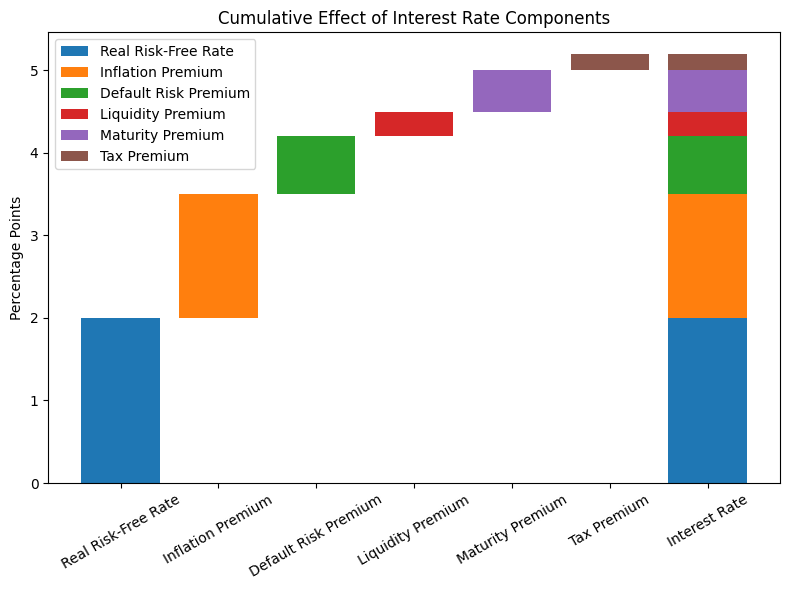

In [13]:
import matplotlib.pyplot as plt

# Example values for each component (in percentage points)
components = {
    "Real Risk-Free Rate": 2.0,
    "Inflation Premium": 1.5,
    "Default Risk Premium": 0.7,
    "Liquidity Premium": 0.3,
    "Maturity Premium": 0.5,
    "Tax Premium": 0.2
}

labels = list(components.keys())
values = list(components.values())

# Calculate cumulative bottoms for stacking
bottoms = [0]
for v in values[:-1]:
    bottoms.append(bottoms[-1] + v)

fig, ax = plt.subplots(figsize=(8, 6))

cumulative_values = [sum(values[:i+1]) for i in range(len(values))]
# Plot individual bars for each component
for i, (label, value, bottom) in enumerate(zip(labels, values, bottoms)):
    ax.bar(label, value, bottom=cumulative_values[i-1] if i > 0 else 0)

# Plot each component as a stacked bar
for i, (label, value, bottom) in enumerate(zip(labels, values, bottoms)):
    ax.bar("Interest Rate", value, bottom=bottom, label=label, color=ax.patches[i].get_facecolor())


ax.set_ylabel("Percentage Points")
ax.set_title("Cumulative Effect of Interest Rate Components")
ax.legend()
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

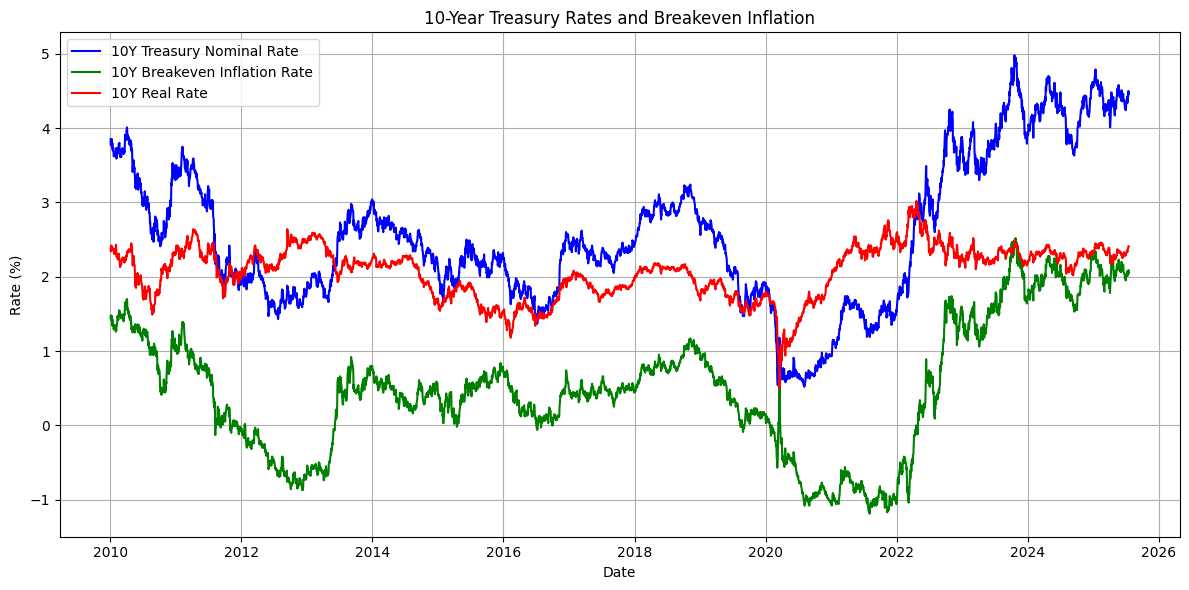

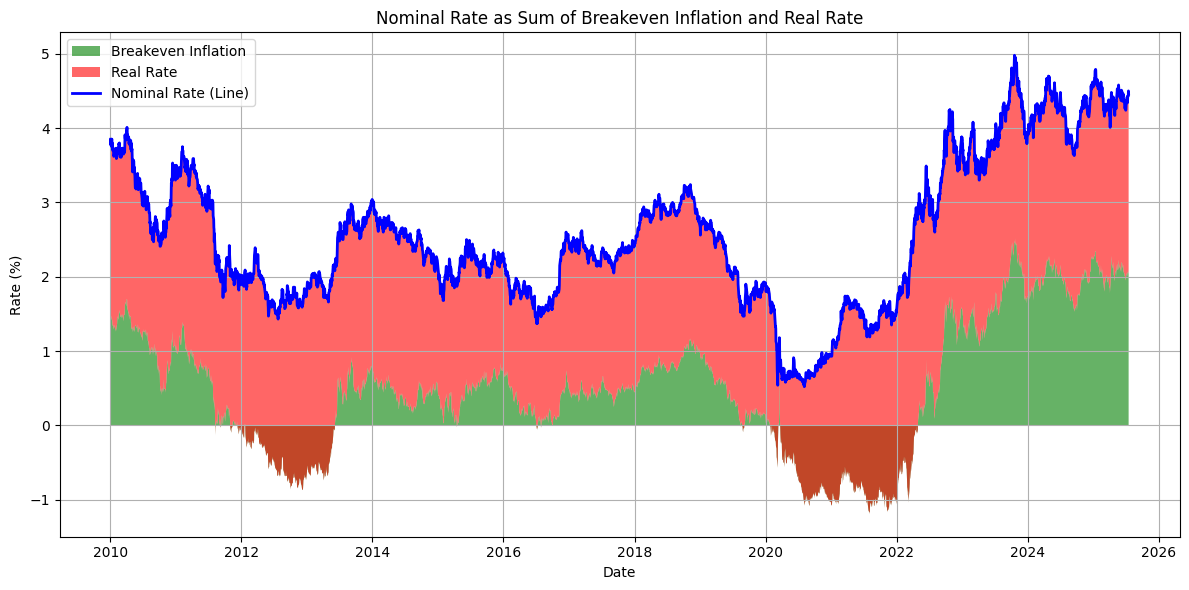

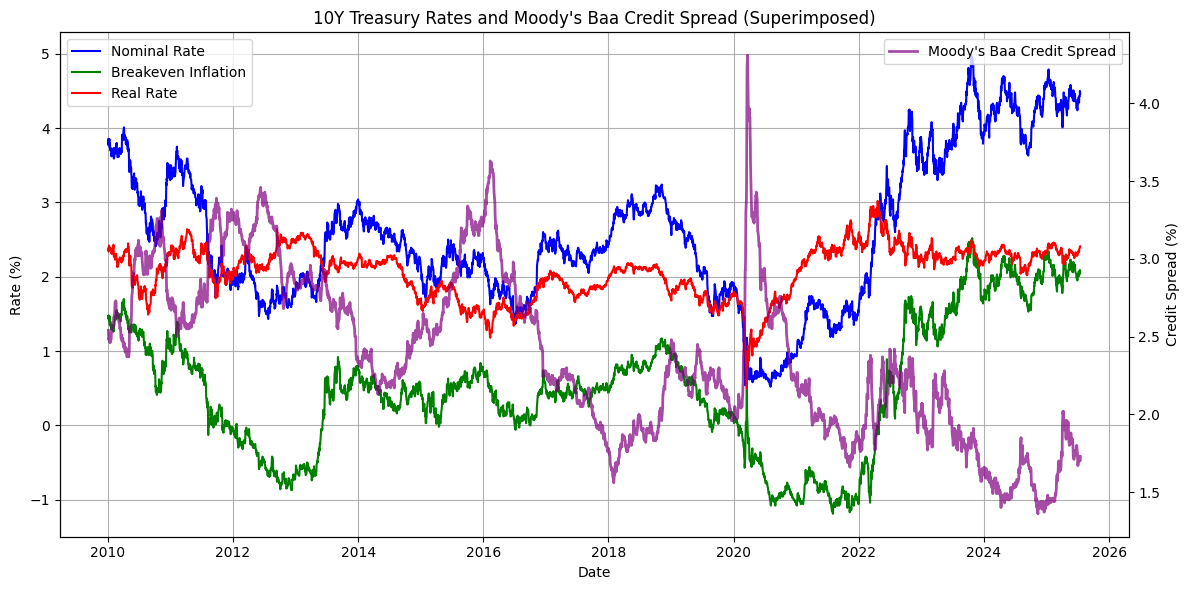

<Figure size 640x480 with 0 Axes>

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as web

def download_and_prepare(start_date='2010-01-01'):
    # Descargar datos
    rates = web.DataReader('DGS10', 'fred', start=start_date)
    breakeven = web.DataReader('DFII10', 'fred', start=start_date)
    credit_spread = web.DataReader('BAA10Y', 'fred', start=start_date)

    # Renombrar columnas
    rates.rename(columns={'DGS10': 'Nominal_Rate'}, inplace=True)
    breakeven.rename(columns={'DFII10': 'Breakeven_Inflation'}, inplace=True)
    credit_spread.rename(columns={'BAA10Y': 'Credit_Spread'}, inplace=True)

    # Concatenar y crear Real Rate
    data = pd.concat([rates, breakeven, credit_spread], axis=1)
    data['Real_Rate'] = data['Nominal_Rate'] - data['Breakeven_Inflation']
    data.dropna(inplace=True)
    return data

def plot_rates(data):
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Nominal_Rate'], label='10Y Treasury Nominal Rate', color='blue')
    plt.plot(data.index, data['Breakeven_Inflation'], label='10Y Breakeven Inflation Rate', color='green')
    plt.plot(data.index, data['Real_Rate'], label='10Y Real Rate', color='red')
    plt.title('10-Year Treasury Rates and Breakeven Inflation')
    plt.xlabel('Date')
    plt.ylabel('Rate (%)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_stacked_area(data):
    plt.figure(figsize=(12, 6))
    plt.stackplot(
        data.index,
        data['Breakeven_Inflation'],
        data['Real_Rate'],
        labels=['Breakeven Inflation', 'Real Rate'],
        colors=['green', 'red'],
        alpha=0.6
    )
    plt.plot(data.index, data['Nominal_Rate'], label='Nominal Rate (Line)', color='blue', linewidth=2)
    plt.title('Nominal Rate as Sum of Breakeven Inflation and Real Rate')
    plt.xlabel('Date')
    plt.ylabel('Rate (%)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_combined_subplots(data):
    # Superimposed plot with twin y-axis (Nominal, Breakeven, Real + Credit Spread)
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Left y-axis: Nominal, Breakeven, Real
    ax1.plot(data.index, data['Nominal_Rate'], label='Nominal Rate', color='blue')
    ax1.plot(data.index, data['Breakeven_Inflation'], label='Breakeven Inflation', color='green')
    ax1.plot(data.index, data['Real_Rate'], label='Real Rate', color='red')
    ax1.set_ylabel('Rate (%)')
    ax1.set_xlabel('Date')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    # Right y-axis: Credit Spread
    ax2 = ax1.twinx()
    ax2.plot(data.index, data['Credit_Spread'], label="Moody's Baa Credit Spread", color='purple', linewidth=2, alpha=0.7)
    ax2.set_ylabel('Credit Spread (%)')
    ax2.legend(loc='upper right')

    plt.title('10Y Treasury Rates and Moody\'s Baa Credit Spread (Superimposed)')
    plt.tight_layout()
    plt.show()


    plt.tight_layout()
    plt.show()

# Ejecutar
data = download_and_prepare()

plot_rates(data)
plot_stacked_area(data)
plot_combined_subplots(data)


In [15]:
from pyfian.time_value.present_value import present_value_annuity

print(present_value_annuity(100, rate=0.1, periods=5))


from pyfian.time_value.present_value import present_value_growing_annuity

print(present_value_growing_annuity(100, growth=0.05, rate=0.1, periods=5))

from pyfian.time_value.mortgage_cash_flows import mortgage_cash_flows

mortgage_cash_flows(principal_balance=200000, annual_rate=0.04, term_months=10)

379.07867694084507
415.0591272329889


,Period,Payment,Interest,Principal,Remaining Balance
0,1,20368.5,666.67,19701.83,180298.17
1,2,20368.5,600.99,19767.50,160530.67
2,3,20368.5,535.10,19833.39,140697.27
3,4,20368.5,468.99,19899.51,120797.77
4,5,20368.5,402.66,19965.84,100831.93
5,6,20368.5,336.11,20032.39,80799.54
6,7,20368.5,269.33,20099.17,60700.37
7,8,20368.5,202.33,20166.16,40534.21
8,9,20368.5,135.11,20233.38,20300.83
9,10,20368.5,67.67,20300.83,0.00
